## comparison to published expressions

samples generated by authors downloaded from here: https://drive.google.com/drive/folders/1nipKCftK2uSfBarrIrQYCnylpje8G9W_

In [1]:
import json

In [2]:
with open('unf_captions_full_11_test.json') as f:
    generated = json.load(f)
    
with open('vqaX_p_full_unfiltered.json') as f:
    authors_generated = json.load(f)

In [3]:
caps = [g['caption'] for g in generated]
a_caps = [g['caption'] for g in authors_generated]

In [4]:
print('different:\n')

for i, (a, b) in enumerate(zip(caps, a_caps)):
    if a == b:
        pass
    else: 
        print(f'{i}\tours:', a)
        print(f'{i}\tauthors:', b, '\n')

different:

196	ours: beer because it is a beer bottle
196	authors: beer because it is amber colored 

588	ours: rice because there are grains and grains
588	authors: rice because there are grains and vegetables 

617	ours: snowboarding because he is riding a snowboard down a snow covered hill
617	authors: skiing because he is on top of a snowy mountain with skis on his feet 

857	ours: yes because she is smiling and holding two hotdogs
857	authors: no because she is smiling and holding two hotdogs 

901	ours: snowboarding because he is jumping off a pile of snow
901	authors: snowboarding because they are using a snowboard to jump over snow 

1209	ours: talking because she is holding a glass of water
1209	authors: talking because she is holding a bottle of water 

1254	ours: yes because it is a stuffed animal
1254	authors: yes because it is a stuffed animal that is hanging from a string 

1405	ours: football because the screen is lit up with a football game on it
1405	authors: soccer b

In [5]:
len(caps)

1968

In [6]:
sum([a == b for a,b in zip(caps, a_caps)]) / len(caps)

0.994410569105691

In [7]:
sum([a != b for a,b in zip(caps, a_caps)]) / len(caps)

0.005589430894308943

In [8]:
sum([a != b for a,b in zip(caps, a_caps)])

11

# Comparison between colour and greyscale settings

(Identical model for both settings - trained on colour images, but images are converted to b/w during inference for greyscale setting)

In [9]:
import json
import nltk
from collections import Counter, defaultdict
from itertools import chain
import re
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def read_file(file):
    with open(file) as f:
        anns = json.load(f)
        ids = [a['image_id'] for a in anns]
        expressions = [a['caption'] for a in anns]
    return ids, expressions


def decompose_answers_explanations(utterances):
    answers, explanations = list(), list()
    errors = 0
    for utt in utterances:
        if ' because ' in utt:
            a, e = utt.split(' because ')
            answers.append(a)
            explanations.append(e)
        else:
            answers.append('#ERROR')
            explanations.append('#ERROR')
            errors += 1
    if errors > 0:
        print(f'{errors} parsing errors!')
        
    return answers, explanations


def get_identical(utt_a, utt_b):
    identical = [c == g for c,g in zip(utt_a, utt_b)]
    identical_ids = np.where(identical)[0].tolist() 
    count = sum(identical)
    return count, identical_ids


def get_comparison(color_caps, greyscale_caps):
        
    # direct comparisons between settings
    color_answers, color_explanations = decompose_answers_explanations(color_caps)
    greyscale_answers, greyscale_explanations = decompose_answers_explanations(greyscale_caps)
    
    comparison = defaultdict(dict)

    n_same_global, same_global_ids = get_identical(color_caps, greyscale_caps)
    n_same_answers, same_answers_ids = get_identical(color_answers, greyscale_answers)
    n_same_explanations, same_explanations_ids = get_identical(color_explanations, greyscale_explanations)

    comparison['global']['n_same'] = n_same_global
    comparison['global']['ids'] = same_global_ids
    comparison['answers']['n_same'] = n_same_answers
    comparison['answers']['ids'] = same_answers_ids
    comparison['explanations']['n_same'] = n_same_explanations
    comparison['explanations']['ids'] = same_explanations_ids
    
    print(f'same expression in {round((comparison["global"]["n_same"] / len(color_caps)) * 100, 2)} % of cases')
    print(f'same answer in {round((comparison["answers"]["n_same"] / len(color_caps)) * 100, 2)} % of cases')
    print(f'same explanation in {round((comparison["explanations"]["n_same"] / len(color_caps)) * 100, 2)} % of cases')
    print('\n')
    
    return comparison


def get_frequency_stats(color_caps, greyscale_caps):
        
    colors = {'blue', 'brown', 'green', 'orange', 'pink', 'purple', 'red', 'yellow'}
    greyscales = {'black', 'gray', 'grey', 'white'}
    meta = {'color', 'colour'}
    baw = {'black and white'}

    keywords = {
        'colors': colors,
        'greyscales': greyscales,
        'colors+grey': colors | greyscales,
        'meta': meta,
        'black_and_white': baw
    }
    
    stats = {
        'color': defaultdict(dict), 
        'greyscale': defaultdict(dict)
    }

    for name, caps in zip(['color', 'greyscale'], [color_caps, greyscale_caps]):
        for key, words in keywords.items():
            q = rf'\b({r"|".join(words)})\b'
            hits = [True if re.search(q,c) else False for c in caps]
            hit_ids = np.where(hits)[0].tolist()
            stats[name][key]['total'] = len(hit_ids)
            stats[name][key]['ratio'] = round((len(hit_ids) / len(caps)) * 100, 2)
            stats[name][key]['ids'] = hit_ids
            
    return stats


def plot_stats(stats):
    
    labels = stats['color'].keys()

    color_vals = [stats['color'][l]['ratio'] for l in labels]
    greyscale_vals = [stats['greyscale'][l]['ratio'] for l in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, color_vals, width, label='colour')
    rects2 = ax.bar(x + width/2, greyscale_vals, width, label='greyscale')

    ax.set_ylabel('% Keyword in Expression')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

val split:
1 parsing errors!
2 parsing errors!
same expression in 39.2 % of cases
same answer in 86.98 % of cases
same explanation in 40.92 % of cases




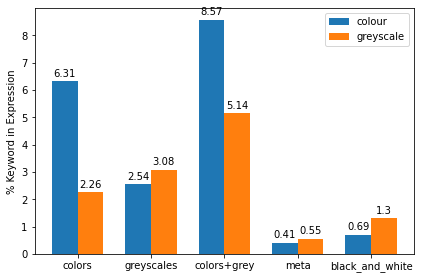

In [11]:
epoch = 11
split = 'val'

print(f'{split} split:')

color_file = f'unf_captions_full_{epoch}_{split}.json'
greyscale_file = f'unf_captions_full_{epoch}_{split}_greyscale.json'

color_ids, color_expressions = read_file(color_file)
greyscale_ids, greyscale_expressions = read_file(greyscale_file)
assert color_ids == greyscale_ids

comparison = get_comparison(color_expressions, greyscale_expressions)
frequency_stats = get_frequency_stats(color_expressions, greyscale_expressions)
plot_stats(frequency_stats)

In [12]:
# does the greyscale model predict colors in the same cases as the color model?
# shared ids with color model for greyscale/color occurrences

color_ratio = frequency_stats["greyscale"]["colors"]["total"] / len(greyscale_expressions)
print(f'greyscale model predicts color in {round(color_ratio * 100, 2)} % of cases (n={frequency_stats["greyscale"]["colors"]["total"]})')

shared_ids = set(frequency_stats['greyscale']['colors']['ids']) & set(frequency_stats['color']['colors']['ids'])
ratio = len(shared_ids) / len(frequency_stats['greyscale']['colors']['ids'])

print(f'color model also predicts color in {round(ratio*100, 2)} % of those cases')

greyscale model predicts color in 2.26 % of cases (n=33)
color model also predicts color in 84.85 % of those cases


In [13]:
# where does the greyscale model predict color?

for i in frequency_stats['greyscale']['colors']['ids']:
    print(greyscale_expressions[i])  # greyscale model expression
    print('----'+color_expressions[i])  # color model expression

no because the sky is blue and there are no clouds
----yes because the sky is blue and there are no clouds
no because the ground is dry and the sky is blue
----no because the ground is dry and the sky is blue
broccoli because it is a green vegetable with a long stem
----broccoli because it is green and has a stem
fall because the trees are green and the sky is clear
----fall because the trees are green and the sky is clear
wood because it is brown and made of wood
----wood because it is a very old style
chocolate because it is a dark brown color
----chocolate because it is brown and has sprinkles
apple because it is round and has a brown skin
----orange because it is round and orange
yes because the sky is blue and there are no clouds
----no because the sky is blue and there are no clouds
no because they are still very green
----no because the bananas are green and not yellow
chocolate because it is dark brown in color
----chocolate because it is brown and has a dark brown color
yes be